# Tortuosity Analysis

In [8]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

RERUN = False #To rerun all computations (False will load from file if they exist)
extension = '.png' #fig file extension
DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/' #On laptop
#DIR  = 'D:/pdm_data/'

In [9]:
def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    return MP_dict

def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        p_dict[p_] = float(v_)
    return p_dict

def ssl_transform(t) :
    N = len(t)
    dt      = [t1-t0 for (t1,t0) in zip(t[range(1,N)],t[range(N-1)])]
    dt_ssl  = [dt_ for dt_ in dt if dt_ > 0] #filtering
    N_ssl   = len(dt_ssl)
    t_ssl   = np.zeros(N_ssl)
    T = 0.0
    for i in range(N_ssl) :
        t_ssl[i] = T
        T += dt_ssl[i]
    return t_ssl

In [10]:
DATA = {}
DM_ = ['0.0E-9',
       '1.0E-13',
       '2.0E-13', 
       '5.0E-13', 
       '1.0E-12',
       '2.0E-12', 
       '5.0E-12', 
       '1.0E-11', 
       '2.0E-11', 
       '5.0E-11', 
       '1.0E-10',
       '2.0E-10',
       '5.0E-10',
       '1.0E-9',
       '2.0E-9',
       '5.0E-9',
       '1.0E-8'
      ]
KEYS   = ['Bent 1000, D='+dm+', CSF=20' for dm in DM_] #ORDERED ARRAY OF KEYS (IMPORTANT TO SORT DATA)
for dm in DM_ : DATA['Bent 1000, D='+dm+', CSF=20'] = DIR+'Bentheimer1000/sl_out_M0_DM'+dm+'_SLSM0_TMAX1E7_CSF20.dat'

PARAM = {}
param = ['DM','SLSM','TMAX','CSF']
for key in DATA : PARAM[key] = Extract_param (DATA[key],param)

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
print('Dataset to load : ' +str(len(DATA)))
PLOT_KEYS = ['Bent 1000, D='+dm_+', CSF=20' for dm_ in ['0.0E-9','1.0E-13', '1.0E-12','1.0E-11', '1.0E-10','1.0E-9','1.0E-8']]
COLOR = { KEYS[i] : color_cycle[i] for i in range(len(PLOT_KEYS))}

Dataset to load : 17


#### Computing traveled distances

In [11]:
UREF = 1.0
REDUCE = False; Nskip = 100
if REDUCE : str1 = '_reduced'
else : str1 = ''
dDNS = {}; dfname = DIR+'Processed_data/dDNS'+str1+'.dat' #Total traveled distance
dxDNS= {}; dxfname= DIR+'Processed_data/dxDNS'+str1+'.dat'#X-direction traveled distance
dyDNS= {}; dyfname= DIR+'Processed_data/dyDNS'+str1+'.dat'#Y-direction traveled distance
dzDNS= {}; dzfname= DIR+'Processed_data/dzDNS'+str1+'.dat'#Z-direction traveled distance
t_ssl = {}; tfname = DIR+'Processed_data/t_ssl'+str1+'.dat'

if os.path.isfile(dfname) : dDNS  = Load_data(dfname)
if os.path.isfile(dxfname): dxDNS = Load_data(dxfname)
if os.path.isfile(dyfname): dyDNS = Load_data(dyfname)
if os.path.isfile(dzfname): dzDNS = Load_data(dzfname)
if os.path.isfile(tfname) : t_ssl = Load_data(tfname)

In [12]:
RERUN  = False
RESAVE = False
print('Checking if new data file...')
for key in DATA :
    if (key not in dDNS) or (key not in dyDNS) or (key not in t_ssl) or (RERUN) :
        RESAVE = True
        print("missing " + key + "data..")
        with open(DATA[key], 'r') as f:
            lines   = (line for line in f if len(line)>15)
            dataDNS = np.genfromtxt(lines)
        del lines
        if REDUCE :
            print(len(dataDNS[:,0]))
            RANGE = range(0,len(dataDNS[:,0]),Nskip)
            dataDNS_reduced = np.zeros((len(RANGE),10))
            for i in range(10) :
                dataDNS_reduced[:,i]=dataDNS[RANGE,i]
            dataDNS = dataDNS_reduced
            del dataDNS_reduced
        T_ = dataDNS[:,0]
        d_ = 0; dx_ = 0; dy_ = 0; dz_ = 0
        D_ = np.zeros(len(T_)); 
        DX_ = np.zeros(len(T_)); DY_ = np.zeros(len(T_)); DZ_ = np.zeros(len(T_))
        for i in range(len(T_)-1):
            dt_ = T_[i+1] - T_[i]
            if dt_ > 0 :
                d_ += np.sqrt(dataDNS[i,4]**2+dataDNS[i,5]**2+dataDNS[i,6]**2)/UREF  * dt_
                dx_+= dataDNS[i,4] * dt_
                dy_+= dataDNS[i,5] * dt_
                dz_+= dataDNS[i,6] * dt_
            D_[i]  = d_; DX_[i] = dx_; DY_[i] = dy_; DZ_[i] = dz_;
        dDNS[key]  = D_
        dxDNS[key] = DX_; dyDNS[key] = DY_; dzDNS[key] = DZ_
        t_ssl[key] = ssl_transform(T_)
        print('\tmean d = '+str(np.mean(dDNS[key])))
        del dataDNS, T_, D_, DX_, DY_, DZ_
print('Done.')

Checking if new data file...
missing Bent 1000, D=2.0E-10, CSF=20data..


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/Bentheimer1000/sl_out_M0_DM2.0E-10_SLSM0_TMAX1E7_CSF20.dat'

In [8]:
if RESAVE :
    print('Saving...')
    Save_data(dDNS,dfname)
    Save_data(dxDNS,dxfname)
    Save_data(dyDNS,dyfname)
    Save_data(dzDNS,dzfname)
    Save_data(t_ssl,tfname)
    print('Done.')
else : print('Done.')

Saving...
Done.


#### Rough comparison of travelled distances

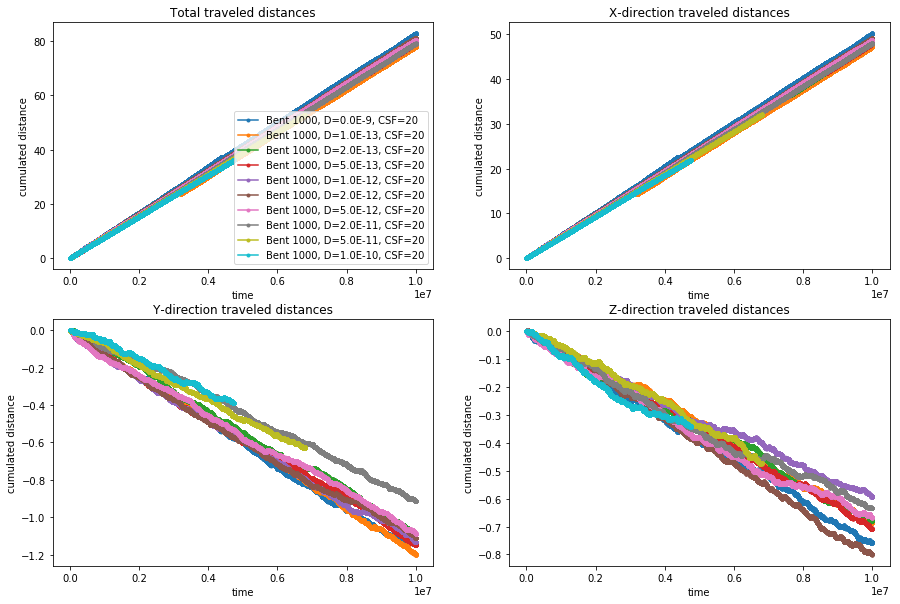

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
Nskip = 100
N_ssl = {}
for key in KEYS : N_ssl[key] = len(t_ssl[key])
(i,j) = (0,0)
axs[i,j].set_title('Total traveled distances')
for key in KEYS : axs[i,j].plot(t_ssl[key][range(0,N_ssl[key],Nskip)],dDNS[key][range(0,N_ssl[key],Nskip)], '.-',color = COLOR[key], label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')
axs[i,j].legend()

(i,j) = (0,1)
axs[i,j].set_title('X-direction traveled distances')
for key in KEYS : axs[i,j].plot(t_ssl[key][range(0,N_ssl[key],Nskip)],dxDNS[key][range(0,N_ssl[key],Nskip)], '.--',color = COLOR[key], label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')

(i,j) = (1,0)
axs[i,j].set_title('Y-direction traveled distances')
for key in KEYS : axs[i,j].plot(t_ssl[key][range(0,N_ssl[key],Nskip)],dyDNS[key][range(0,N_ssl[key],Nskip)], '.--',color = COLOR[key], label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')

(i,j) = (1,1)
axs[i,j].set_title('Z-direction traveled distances')
for key in KEYS : axs[i,j].plot(t_ssl[key][range(0,N_ssl[key],Nskip)],dzDNS[key][range(0,N_ssl[key],Nskip)], '.--',color = COLOR[key], label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')

plt.savefig(DIR+'Figures/traveled_distances'+extension)

#### Same time comparison 

In [11]:
TMAX = []
for key in KEYS :
    TMAX.append(t_ssl[key][-1])
TMAXmin = min(TMAX)
Tcomp = {}; Ncomp = {};
for key in KEYS : 
    Tcomp[key] = [t_ for t_ in t_ssl[key] if t_ <= TMAXmin]
    Ncomp[key] = len(Tcomp[key])
    #print(key + '\t: Tmax = '+str(t_ssl[key][-1])+',\t Ncomp = '+str(Ncomp[key])+',\t len Tcomp = '+str(len(Tcomp[key])))

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

(i,j) = (0,0)
axs[i,j].set_title('Total traveled distances')
for key in KEYS : axs[i,j].plot(Tcomp[key],dDNS[key][:Ncomp[key]], '.-',color = COLOR[key], label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')
axs[i,j].legend()

(i,j) = (0,1)
axs[i,j].set_title('X-direction traveled distances')
for key in KEYS : axs[i,j].plot(Tcomp[key],dxDNS[key][:Ncomp[key]], '.--',color = COLOR[key], label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')

(i,j) = (1,0)
axs[i,j].set_title('Y-direction traveled distances')
for key in KEYS : axs[i,j].plot(Tcomp[key],dyDNS[key][:Ncomp[key]], '.--',color = COLOR[key], label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')

(i,j) = (1,1)
axs[i,j].set_title('Z-direction traveled distances')
for key in KEYS : axs[i,j].plot(Tcomp[key],dzDNS[key][:Ncomp[key]], '.--',color = COLOR[key], label = key)
axs[i,j].set_xlabel('time')
axs[i,j].set_ylabel('cumulated distance')

plt.savefig(DIR+'Figures/traveled_distances_same_time'+extension)

#### Computing tortuosity

In [13]:
KAPPA = {}
for key in KEYS :
    KAPPA[key] = [d_/dx_ for (d_,dx_) in zip(dDNS[key],dxDNS[key]) if dx_ != 0]
kmean = []; kstd = []
for key in KEYS :
    kmean.append(np.mean(KAPPA[key]))
    kstd.append(np.std(KAPPA[key]))
Kall = np.mean(kmean); Kallstd = np.std(kmean)

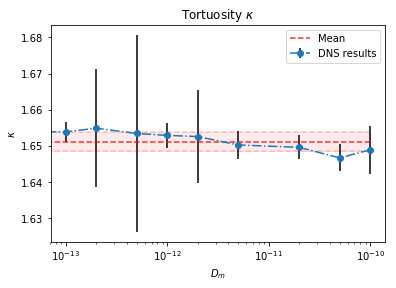

In [14]:
DM = [PARAM[key]['DM'] for key in KEYS]
KMEAN=np.array([Kall for dm_ in DM])
KPSTD=np.array([Kall+Kallstd for dm_ in DM])
KMSTD=np.array([Kall-Kallstd for dm_ in DM])
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.set_title(r'Tortuosity $\kappa$');
ax.plot(DM,KMEAN,'r--',alpha=0.8, label = 'Mean')
ax.plot(DM,KPSTD,'r--',alpha=0.2)
ax.plot(DM,KMSTD,'r--',alpha=0.2)
ax.fill_between(DM,KMSTD, KPSTD, color='r', alpha=0.08) 
ax.errorbar(DM, kmean, kstd,fmt='-.o', ecolor = 'k',label ='DNS results', capthick=2)
ax.set_xscale('log');
ax.set_xlabel(r'$D_m$');
ax.set_ylabel(r'$\kappa$');
ax.legend()
plt.savefig(DIR+'Figures/tortuosity'+extension)